# Deep Learning - Exercise 5

This lecture is about advanced topics of the CNN such as Autoencoder for image reconstruction and Variatioanl autoencoder for generating images.

We use MNIST dataset for the tasks as it is quite easy to process.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_05.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_05.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19

from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
from io import BytesIO
from skimage.transform import resize
import cv2
import scipy

tf.version.VERSION

'2.11.0'

In [5]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28,28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()
    
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3]-1:
                activation_index += 1
                
def compute_metrics(y_true, y_pred, show_confusion_matrix=False):
    print(f'\tAccuracy: {accuracy_score(y_true, y_pred)*100:8.2f}%')
    if (show_confusion_matrix):
        print('\tConfusion matrix:\n', confusion_matrix(y_true, y_pred))

## 🔎 What is autoencoder? 🔎
* The autoencoder is a special type of neural network that is able to learn without the classes just from the input data. 
    * It is equivalent to the feature extraction from the data.
* 🔎 Can you name any use-case for such model?
* What is latent vector?
* How can we compare two images?

![Arch01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_enc_arch.png?raw=true)

## The autoencoder uses binary-crossentropy as loss function
* How is the function used?


$BCE = -\frac{1}{N}\sum_{i=1}^{N}y_i*log(p(y_i))+(1-y_i*log(1-p(y_i)))$

* Beware the asymetry of the BCE function
* **during backpropagation this loss cares more about very bright (1) and very dark pixels (0), but puts less effort on optimizing middle tones (0.5).**

* Give the true value is 0.2, and autoencoder A predicts 0.1 while autoencoder B predicts 0.3. 
    * The loss for A would be: $−(0.2 * log_{10}(0.1) + (1−0.2) * log_{10}(1−0.2)) = 0.278$    
    * The loss for B would be: $−(0.2 * log_{10}(0.3) + (1−0.2) * log_{10}(1−0.3)) = 0.228$

Check [this](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) or [this](https://stats.stackexchange.com/questions/394582/why-is-binary-cross-entropy-or-log-loss-used-in-autoencoders-for-non-binary-da) for more details

# Let's start

## Load the data first

In [8]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)

Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


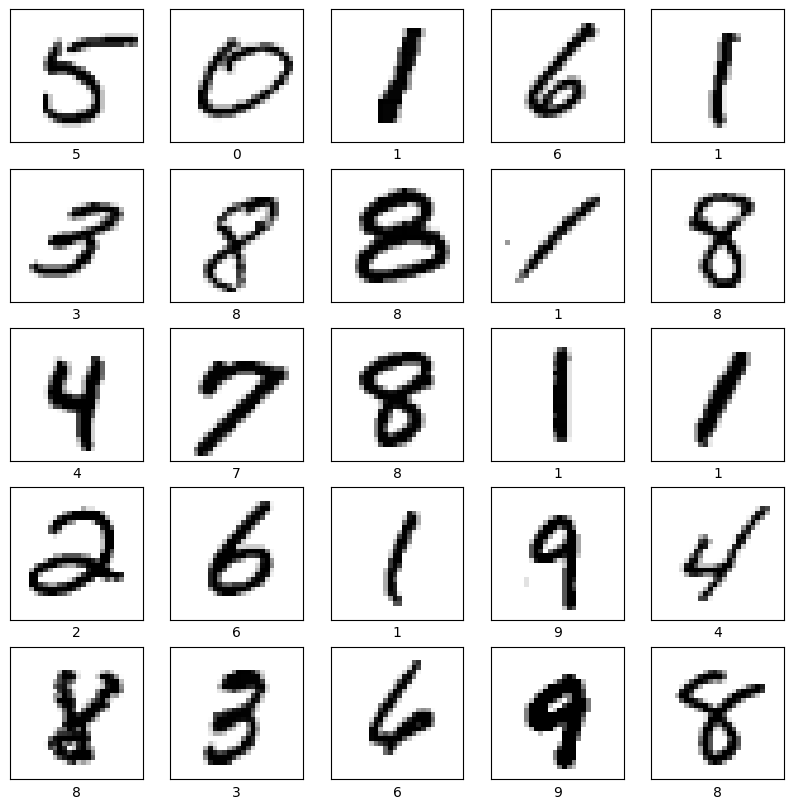

In [9]:
show_example(train_x, train_y, class_names)

## Extract single image shape

In [17]:
input_shape = train_x.shape[1:]
input_shape

(28, 28, 1)

## The model definition is really straightforward and I bet that you would be able to define the architecture using the knowledge from previous lectures
* Why do we use **padding='same'**?
* Why do we have 128 numbers in the latent vector?
* What does the **UpSampling2D** layer?
    * What interpolation methods do you know?

In [18]:
autoencoder = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    # a 128 values of the minimized knowledge / features
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.UpSampling2D((2,2)),
    
    keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
])

autoencoder.summary()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           2312      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)          0

2023-03-28 15:04:58.681156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:05:01.187676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-03-28 15:05:01.188361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7393 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-03-28 15:05:01.188901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/de

## Fit the model

Epoch 1/10


2023-03-28 15:09:43.001686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8303
2023-03-28 15:09:48.220246: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 15:09:49.760141: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f49fbcfef50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 15:09:49.760203: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-03-28 15:09:49.760216: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-03-28 15:09:49.760225: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-03-28 15:09:49.760234: I tensorflow/compiler/xla/service/service.cc:181]   Str

375/375 [==============================] - 16s 14ms/step - loss: 0.1812 - accuracy: 0.8000 - val_loss: 0.1251 - val_accuracy: 0.8090
Epoch 2/10
375/375 [==============================] - 5s 12ms/step - loss: 0.1167 - accuracy: 0.8092 - val_loss: 0.1122 - val_accuracy: 0.8093
Epoch 3/10
375/375 [==============================] - 5s 12ms/step - loss: 0.1080 - accuracy: 0.8109 - val_loss: 0.1053 - val_accuracy: 0.8110
Epoch 4/10
375/375 [==============================] - 5s 12ms/step - loss: 0.1031 - accuracy: 0.8117 - val_loss: 0.1029 - val_accuracy: 0.8111
Epoch 5/10
375/375 [==============================] - 5s 12ms/step - loss: 0.0997 - accuracy: 0.8123 - val_loss: 0.0980 - val_accuracy: 0.8128
Epoch 6/10
375/375 [==============================] - 5s 12ms/step - loss: 0.0972 - accuracy: 0.8126 - val_loss: 0.0961 - val_accuracy: 0.8134
Epoch 7/10
375/375 [==============================] - 5s 12ms/step - loss: 0.0951 - accuracy: 0.8129 - val_loss: 0.0948 - val_accuracy: 0.8129
Epoch 8/1

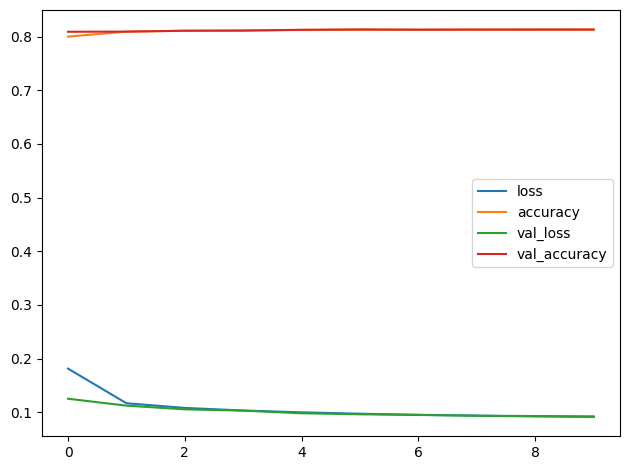

In [19]:
history = autoencoder.fit(train_x, train_x, validation_data=(valid_x, valid_x), epochs=10, batch_size=128)

show_history(history)

# Now you can generate original and reconstructed images
* You feed-forward the test image set and the model will provide the reconstructed image on the output
* 🔎 How good is the reconstruction (just visually 🙂)?
    * On what parameter does the quality depend the most? 
    * Do you think the output is blurry? Why?
        * Remember the BCE loss function caveat? Take a look at the white pixels brightness.

313/313 [==============================] - 1s 3ms/step


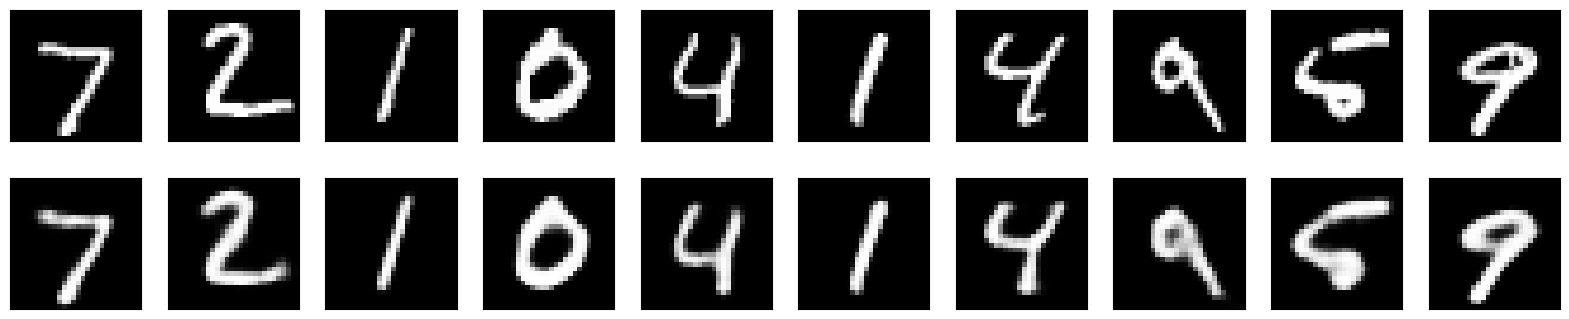

In [20]:
predicted = autoencoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## We can even vizualize the encoded vectors
* We will just re-construct the encoder architecture and feed it with our pre-trained weights

In [22]:
encoder = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),    
    keras.layers.MaxPooling2D((2, 2), padding='same'),
])

# encoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder.set_weights(autoencoder.get_weights()[:6])

for layer in encoder.layers:
    layer.trainable = False

encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 8)           2312      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 8)         

## Take a look at the latent vectors
* Do you see any difference among the vectors?
    * 💡 Compare *4* to *4* and then *4* to *1*

313/313 [==============================] - 1s 2ms/step


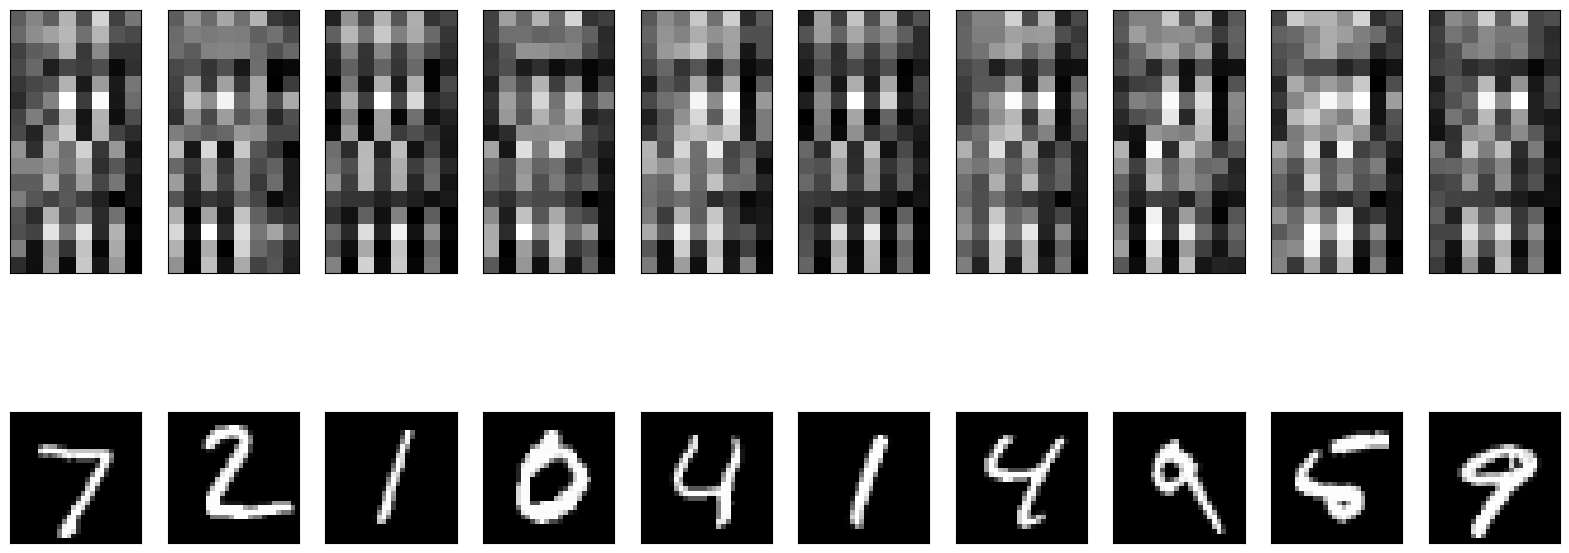

In [23]:
encoded = encoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(encoded[i].reshape(8, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(test_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Hey, but the classifier also had the latent vector after the encoder part! 🤔
* The latent vector generated using the autoencoder principle generate a compressed representation of the input.
* Both models follow different set of goals and the goal of the autoencoder is different than from the classifier
    * Autoencoder want to compress the image into the latent vector in a way that it can be reconstructed with the best quality
    * Classifier want to embed the image into a latent vector as well, but the main goal is to create such representation that the vectors are different from each other so the model can distinguish among the images
* Some variants of encoder are able to generate better representation with some features - a sparse autoencoders that generate sparse representation for example.
    * What is sparcity? Why would anyone want such property?

### Can we use latent vectors from just the **encoder** part of the autoencoder as a *feature engineering* step for classifier? 🤔
* Yes, it is possible but given the different properties of the latent vectors, there would be a negative accuracy impact
* **TL;DR: Use classifiers for classification tasks and autoencoder for autoencoder tasks**





# Outlier Detection With Autoencoders

> 💡If you cannot compress it, there is probably something wrong with it

* A classical obstacle you stumble upon in data science and machine learning is outliers. 
* The concept of an outlier is intuitively clear to a human, yet there is no generally meaningful mathematical definition apart from simple hacks that involve the standard deviation or the interquartile range.

* **By definition, outliers are not like other data points.**

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_meme_01.png?raw=true)

* 🔎 Can you give some examples of outlier data?

## How do we use autoencoders for the task?
* 💡 A good autoencoder should be able to compress (encode) data into fewer dimensions and then decompress (decode) it again without introducing many errors
    * An autoencoder tries to learn good encodings for a given dataset.
    * Since most data points in the dataset are not outliers, the autoencoder will be influenced most by the normal data
* **If the autoencoder introduces a large error for some data point, this data point might be an outlier.**

## We can test it out
* First, create sample dataset of 25 images

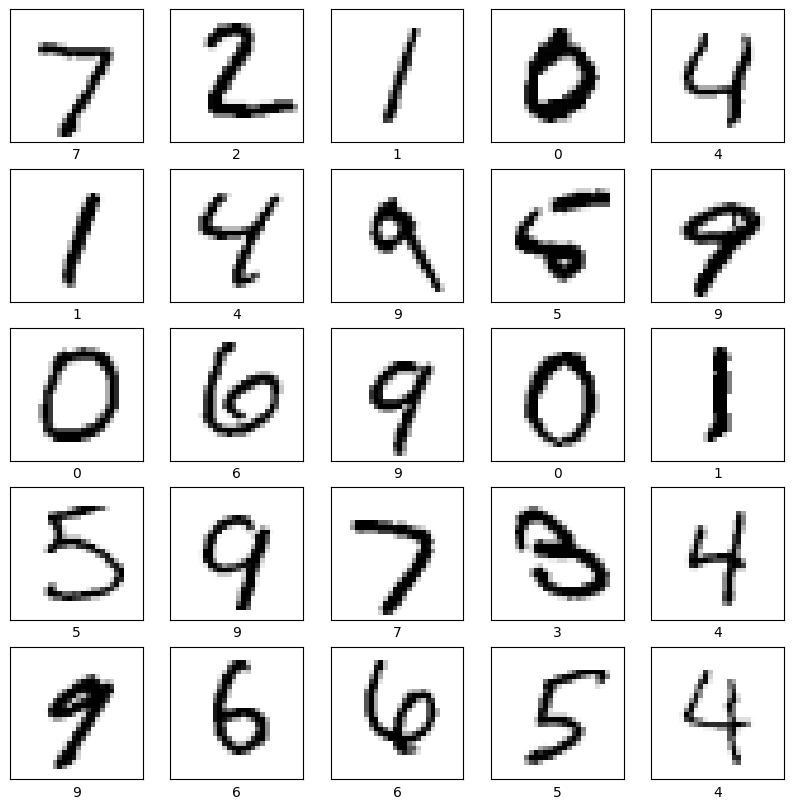

In [24]:
sample_x = test_x[:25]
sample_y = test_y[:25]

show_example(sample_x, sample_y, class_names)

## Now we can add a noise in the data to create **outliers**

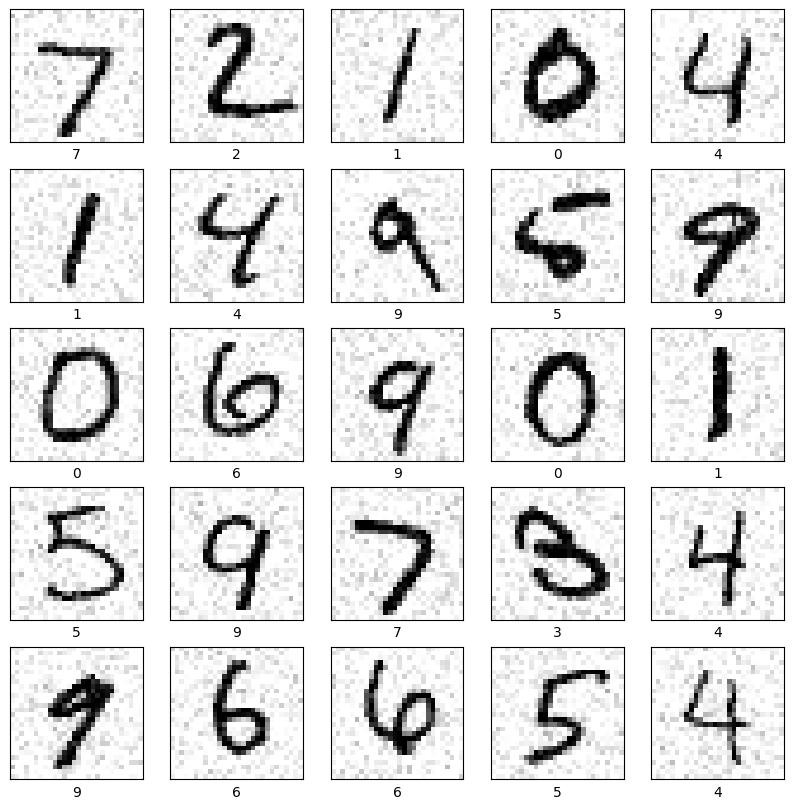

In [33]:
modified_x = np.clip(sample_x + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=sample_x.shape), 0., 1.) 
modified_y = sample_y
show_example(modified_x, modified_y, class_names)

## The first step is to create the reconstructed representation for the **original** samples

1/1 [==============================] - 0s 88ms/step


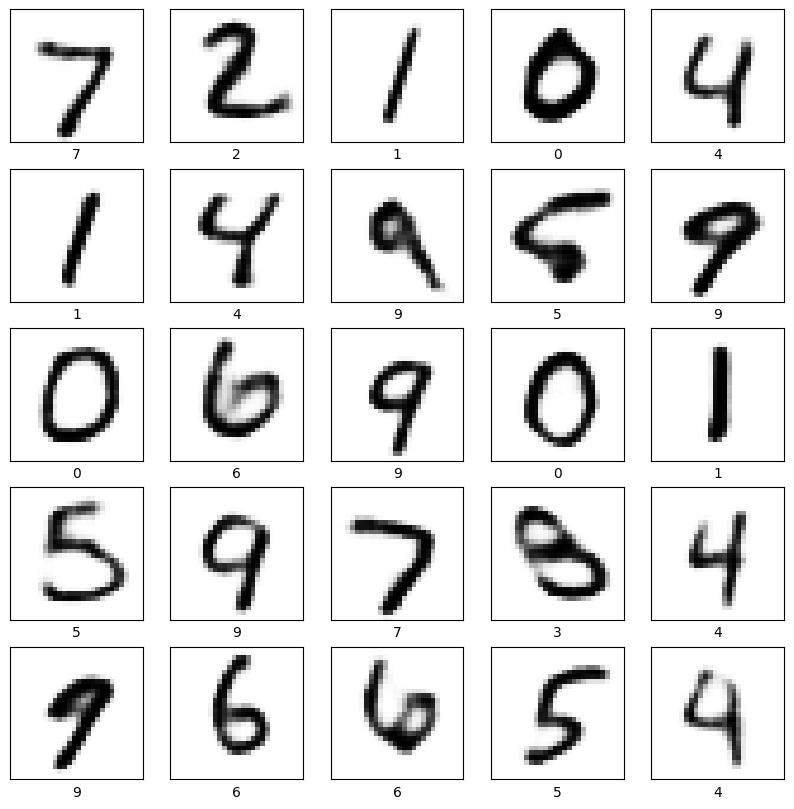

In [26]:
sample_predicted = autoencoder.predict(sample_x)
show_example(sample_predicted, sample_y, class_names)

In [34]:
## The first step is to create the reconstructed representation for the **noisy** samples

1/1 [==============================] - 0s 36ms/step


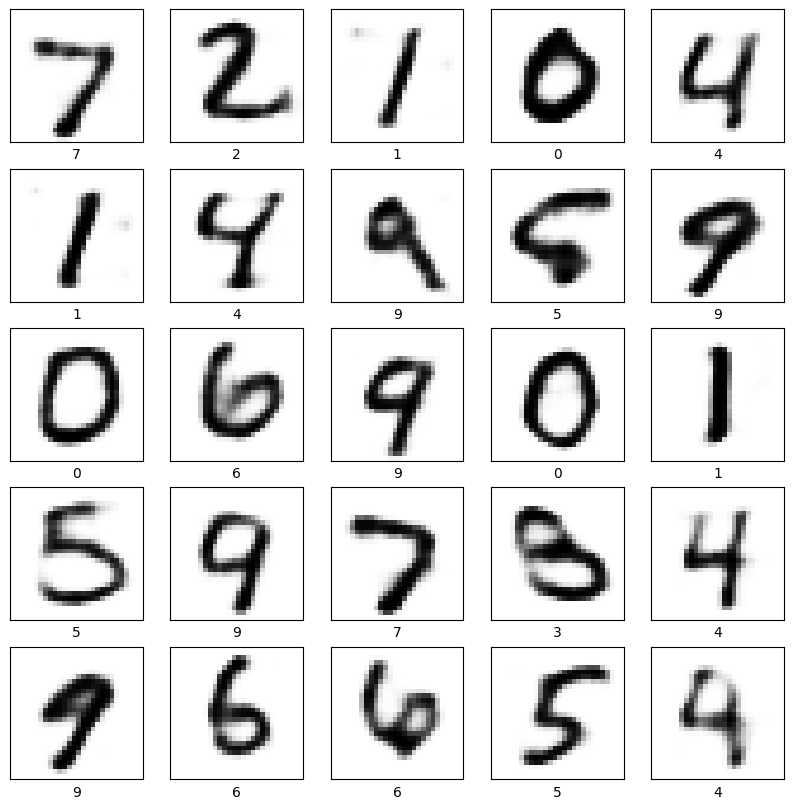

In [35]:
modified_pred = autoencoder.predict(modified_x)
show_example(modified_pred, modified_y, class_names)

## Now we can compute the reconstruction errors for both of the image sets using Frobenius norm
* https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
* Frobenius norm (Euclidean norm) ~ Root of squared errors

In [40]:
sample_norms = [np.linalg.norm(sample_x[i].reshape(28,28)- sample_predicted[i].reshape(28,28)) for i in range(len(sample_x))]
modified_norms = [np.linalg.norm(modified_x[i].reshape(28,28)- modified_pred[i].reshape(28,28)) for i in range(len(sample_x))]

sample_mean, sample_std = np.mean(sample_norms), np.std(sample_norms)
modified_mean, modified_std = np.mean(modified_norms), np.std(modified_norms)

sample_mean, modified_mean

(2.5746143151857916, 3.971150819666936)

## And in the final step we can visualize the errors distribution
* Can you see the outliers in the plot?
    * How would you detect them?

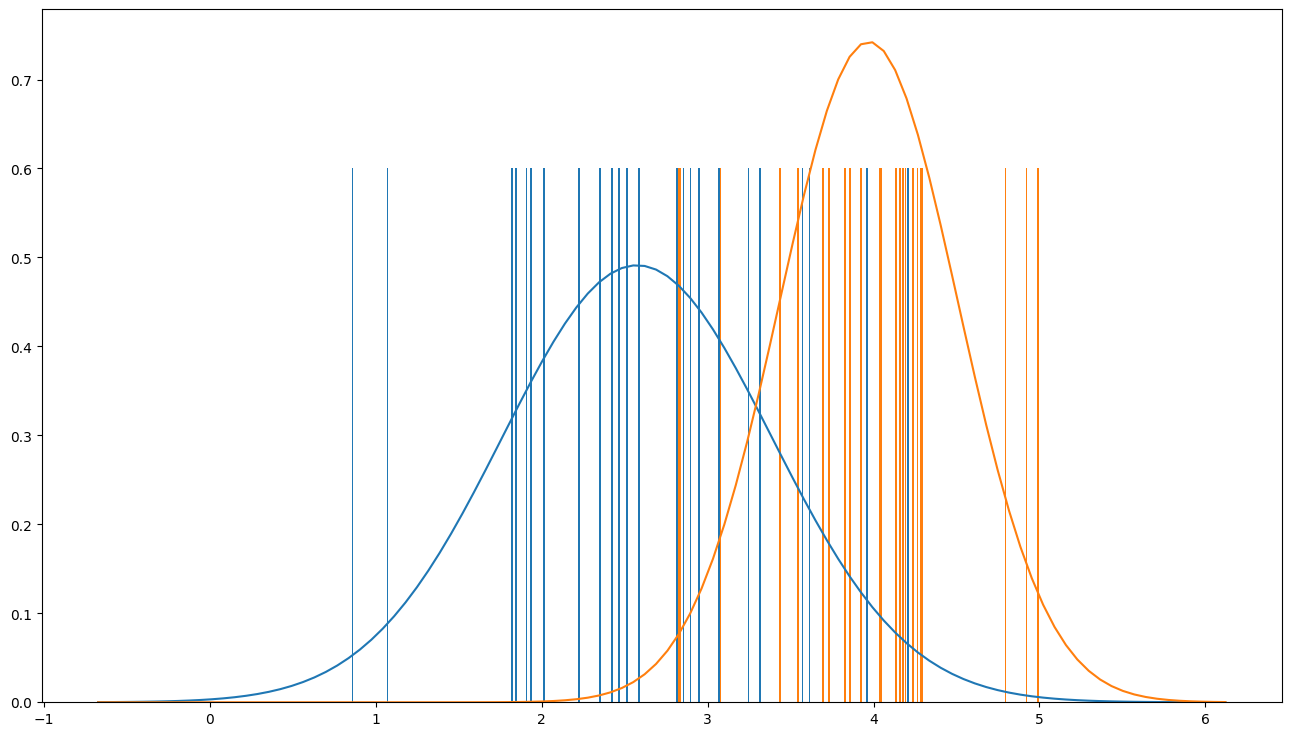

In [39]:
plt.figure(figsize=(16,9))
xmin = np.min([sample_mean-4*sample_std, modified_mean-4*modified_std])
xmax = np.max([sample_mean+4*sample_std, modified_mean+4*modified_std])

x = np.linspace(xmin, xmax, 100)

y = scipy.stats.norm.pdf(x,sample_mean,sample_std)

plt.plot(x,y)

y = scipy.stats.norm.pdf(x,modified_mean,modified_std)

plt.plot(x,y)

plt.bar(x=sample_norms, height=[0.6 for x in sample_norms], width=0.01)
plt.bar(x=modified_norms, height=[0.6 for x in sample_norms], width=0.01)
plt.show()

# Variational Autoencoder (VAE)
* A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space. 
* Rather than building an encoder which outputs a single value to describe each latent state attribute, we'll formulate our encoder to describe a probability distribution for each latent attribute

* Let's suppose we've trained an autoencoder model on a large dataset of faces with a encoding dimension of 6. 
    * An ideal autoencoder will learn descriptive attributes of faces such as skin color, whether or not the person is wearing glasses, etc. in an attempt to describe an observation in some compressed representation.

* You can see [this](https://www.jeremyjordan.me/variational-autoencoders/) for very good explanation

In [43]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)

Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## ⚠  There are some differences to the traditional classification task approach

* We will reshape data from 28x28 to 32x32x1 shape
    * We will use subsampling/pooling in the model so we expect division of width and height by 2 with each of the subsampling step
    * ⚠ Dividing 28 by 2 multiple times will lead to sequence -> 28 >> 14 >> 7 >> ... Number 7 could be an issue for reconstruction because the subsampling uses integer division (7 / 2 = 3) but 2*3 = 6

* Resizing to 32x32 will save us from this issue because we will get sequence 32 >> 16 >> 8 >> 4 >> 2 >> 1 which is no problem to reconstruct

In [44]:
size = 32

train_x_res = np.array([cv2.resize(x, (size, size)) for x in train_x])
test_x_res = np.array([cv2.resize(x, (size, size)) for x in test_x])
valid_x_res = np.array([cv2.resize(x, (size, size)) for x in valid_x])

train_x_r = train_x_res.reshape(-1, size, size, 1).astype('float32')
test_x_r = test_x_res.reshape(-1, size, size, 1).astype('float32')
valid_x_r = valid_x_res.reshape(-1, size, size, 1).astype('float32')

## Check the shapes

In [45]:
train_x_r.shape, test_x_res.shape, valid_x_res.shape

((48000, 32, 32, 1), (10000, 32, 32), (12000, 32, 32))

In [46]:
input_shape = train_x_r.shape[1:]
input_shape

(32, 32, 1)

### Just for the compatibility of TF2 version

In [56]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Set the latent vector dimension

In [84]:
latent_dim = 20

In [85]:
def sampling(args):
    mean_mu, log_var = args
    epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + keras.backend.exp(log_var/2)*epsilon

In [86]:
encoder_input = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(28, (3,3), strides=2, padding='same', activation='relu')(encoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

before_flatten_shape = keras.backend.int_shape(x)[1:]
print(before_flatten_shape)

x = keras.layers.Flatten()(x)
mean_mu = keras.layers.Dense(latent_dim, name='mean_mu')(x)
log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
encoder_output = keras.layers.Lambda(sampling)([mean_mu, log_var])

enc_model = keras.Model(encoder_input, encoder_output)
enc_model.summary()

(8, 8, 64)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 28)   280         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 16, 16, 28)  112         ['conv2d_16[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_17 (Conv2D)             (None, 8, 8, 64)     16192       ['batch_normaliz

In [87]:
decoder_input = keras.layers.Input(shape = (latent_dim,) , name = 'decoder_input')
x = keras.layers.Dense(np.prod(before_flatten_shape))(decoder_input)
x = keras.layers.Reshape(before_flatten_shape)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = keras.layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')(x)
decoder_output = x

dec_model = keras.Model(decoder_input, decoder_output)
dec_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 20)]              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              86016     
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 1)        1153      
 ranspose)                                                       
                                                                 
Total params: 161,025
Trainable params: 161,025
Non-traina

In [88]:
vae_input = encoder_input

vae_output = dec_model(encoder_output)

vae_model = keras.Model(vae_input, vae_output)

In [89]:
def total_loss_closure(mean_mu, log_var):
    def r_loss(y_true, y_pred):
        return keras.backend.mean(keras.backend.square(y_true - y_pred), axis=[0, 1])

    def kl_loss(y_true, y_pred):
        kl_loss =  -0.5 * keras.backend.sum(1 + log_var - keras.backend.square(mean_mu) - keras.backend.exp(log_var), axis = 1)
        return kl_loss

    def loss(y_true, y_pred):
        LOSS_FACTOR = 10000
        return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    return loss

In [90]:
vae_model.compile(optimizer='adam', loss = total_loss_closure(mean_mu, log_var))

In [91]:
batch_size = 128
epochs = 10
history = vae_model.fit(train_x_r, train_x_r, validation_data=(valid_x_r, valid_x_r), epochs=epochs, batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10


2023-03-28 16:33:21.240915: W tensorflow/c/c_api.cc:291] Operation '{name:'training_4/Adam/batch_normalization_7/beta/v/Assign' id:2775 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/batch_normalization_7/beta/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/batch_normalization_7/beta/v, training_4/Adam/batch_normalization_7/beta/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - ETA: 0s - loss: 305.6232

2023-03-28 16:33:26.868648: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_2/mul' id:2375 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/model_10_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - 7s 137us/sample - loss: 305.6232 - val_loss: 276.3269
Epoch 2/10
48000/48000 [==============================] - 6s 119us/sample - loss: 150.7293 - val_loss: 142.3931
Epoch 3/10
48000/48000 [==============================] - 6s 119us/sample - loss: 133.2006 - val_loss: 127.7602
Epoch 4/10
48000/48000 [==============================] - 6s 119us/sample - loss: 124.1140 - val_loss: 122.3853
Epoch 5/10
48000/48000 [==============================] - 6s 118us/sample - loss: 118.2592 - val_loss: 116.0506
Epoch 6/10
48000/48000 [==============================] - 6s 119us/sample - loss: 113.5632 - val_loss: 112.2860
Epoch 7/10
48000/48000 [==============================] - 6s 120us/sample - loss: 109.5293 - val_loss: 108.1953
Epoch 8/10
48000/48000 [==============================] - 6s 119us/sample - loss: 106.5677 - val_loss: 108.9113
Epoch 9/10
48000/48000 [==============================] - 6s 120us/sample - loss: 104.3828 - val_loss: 103.9195
Epo

2023-03-28 16:34:19.171336: W tensorflow/c/c_api.cc:291] Operation '{name:'model_10/conv2d_transpose_7/Sigmoid' id:2343 op device:{requested: '', assigned: ''} def:{{{node model_10/conv2d_transpose_7/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](model_10/conv2d_transpose_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


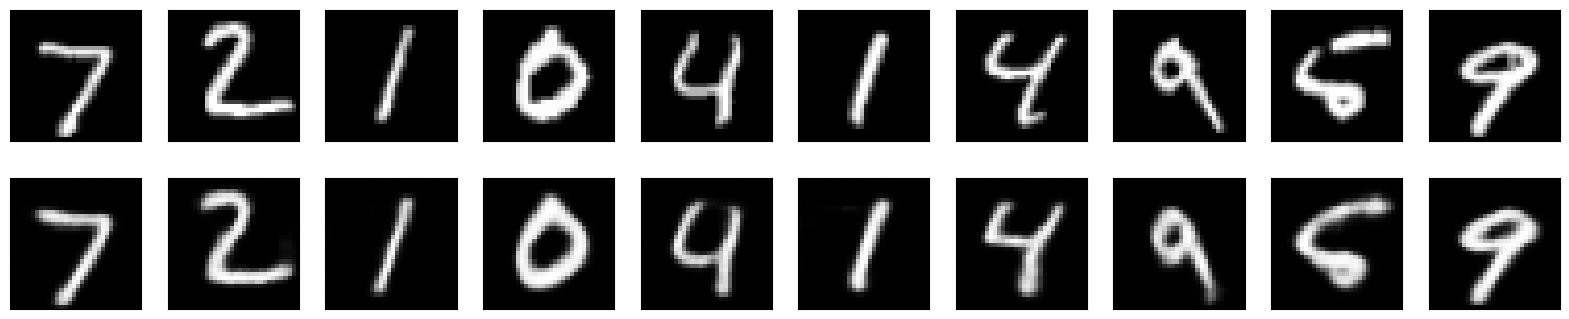

In [92]:
predicted = vae_model.predict(test_x_r)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_x_r[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(predicted[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2023-03-28 16:34:20.961088: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_transpose_7/Sigmoid' id:2293 op device:{requested: '', assigned: ''} def:{{{node conv2d_transpose_7/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_transpose_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


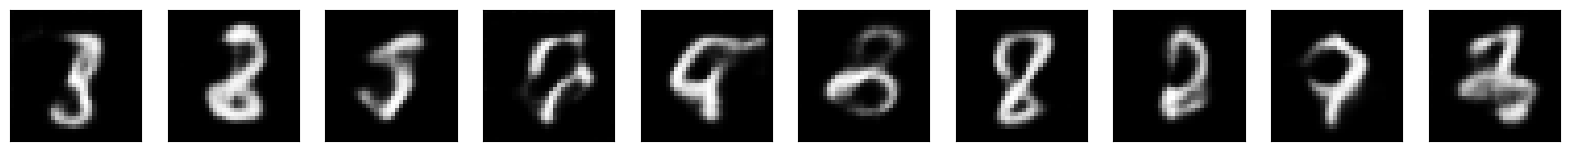

In [93]:
n = 10
reconst_images = dec_model.predict(np.random.normal(0,1,size=(n,latent_dim)))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(reconst_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [83]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 2
    digit_size = 32
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(dec_model)

[ 2.          1.9798995   1.95979899  1.93969849  1.91959799  1.89949749
  1.87939698  1.85929648  1.83919598  1.81909548  1.79899497  1.77889447
  1.75879397  1.73869347  1.71859296  1.69849246  1.67839196  1.65829146
  1.63819095  1.61809045  1.59798995  1.57788945  1.55778894  1.53768844
  1.51758794  1.49748744  1.47738693  1.45728643  1.43718593  1.41708543
  1.39698492  1.37688442  1.35678392  1.33668342  1.31658291  1.29648241
  1.27638191  1.25628141  1.2361809   1.2160804   1.1959799   1.1758794
  1.15577889  1.13567839  1.11557789  1.09547739  1.07537688  1.05527638
  1.03517588  1.01507538  0.99497487  0.97487437  0.95477387  0.93467337
  0.91457286  0.89447236  0.87437186  0.85427136  0.83417085  0.81407035
  0.79396985  0.77386935  0.75376884  0.73366834  0.71356784  0.69346734
  0.67336683  0.65326633  0.63316583  0.61306533  0.59296482  0.57286432
  0.55276382  0.53266332  0.51256281  0.49246231  0.47236181  0.45226131
  0.4321608   0.4120603   0.3919598   0.3718593   0.

ValueError: Error when checking input: expected decoder_input to have shape (200,) but got array with shape (2,)

## Tasks for the lecture (2p)

1) Implement the autoencoder that do the image denoising, implement it on the data defined below. - **(2p)**
    * The denoising autoencoder is a autoencoder that will learn how to remove random noise from the images.
        * First, noisy images have to be generated.
        * Then the autoencoder need to be created and trained.
        * Then denosed images may be reconstructed.
    * Experiment with **noise_factor** values of **0.1, 0.5, 0.9** and write down a short summary about the reconstruction capabilities of the model
        

In [ ]:
noise_factor = 0.5
noisy_train_x = np.clip(train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape), 0., 1.)
noisy_valid_x = np.clip(valid_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_x.shape), 0., 1.)
noisy_test_x = np.clip(test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape), 0., 1.) 


n = 10
plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(noisy_train_x[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()